# Parameter Estimation using PETAb Data

This notebook implements parameter estimation for the JAK-STAT model using experimental data defined in PETAb format.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bngl_simulator import BNGLSimulator
from parameter_estimator import ParameterEstimator

## Load PETAb Files

PETAb defines a standardized format for parameter estimation problems:
- **conditions.tsv**: Experimental conditions (L1_0, L2_0 values)
- **measurements.tsv**: Experimental measurements with timepoints
- **observables.tsv**: Observable definitions with scaling and noise
- **parameters.tsv**: Parameter bounds and estimation flags

In [9]:
# Load PETAb files
conditions_df = pd.read_csv('../petab_files/conditions.tsv', sep='\t')
measurements_df = pd.read_csv('../petab_files/measurements.tsv', sep='\t')
observables_df = pd.read_csv('../petab_files/observables.tsv', sep='\t')
parameters_df = pd.read_csv('../petab_files/parameters.tsv', sep='\t')

print(f"Loaded {len(conditions_df)} experimental conditions")
print(f"Loaded {len(measurements_df)} measurements")
print(f"Loaded {len(observables_df)} observables")
print(f"Loaded {len(parameters_df)} parameters")

# Filter parameters to estimate (estimate=1)
params_to_estimate = parameters_df[parameters_df['estimate'] == 1]
print(f"\nParameters to estimate: {len(params_to_estimate)}")
print(f"Parameter names: {params_to_estimate['parameterId'].tolist()}")

Loaded 15 experimental conditions
Loaded 210 measurements
Loaded 2 observables
Loaded 50 parameters

Parameters to estimate: 48
Parameter names: ['il10_complex_jak1_binding', 'SOCS3_il6r_unbinding', 'il6_jak1_med_STAT1_act', 'pSTAT1_rec_dissoc', 'il6_complex_jak2_binding', 'JAK2_0', 'SOCS3_gp130_binding', 'SOCS3_gp130_unbinding', 'il6_complex_jak2_unbinding', 'SOCS3_il6r_binding', 'SOCS1_jak1_unbinding', 'STAT3_SOCS1_ind', 'il6_complex_jak1_unbinding', 'il10_complex_jak1_unbinding', 'il10_il10r1_unbinding', 'STAT1_SOCS3_ind', 'il6r_gp130_binding', 'GP130_0', 'il10_jak1_med_STAT3_act', 'IL6R_0', 'S3_0', 'S1_0', 'JAK1_0', 'PTP3_0', 'pSTAT3_rec_dissoc', 'il6_complex_jak1_binding', 'il10_jak1_med_STAT1_act', 'il10r1_il10r2_unbinding', 'il10r1_il10r2_binding', 'PTP_med_STAT3_deact', 'il6r_gp130_unbinding', 'il10_il10r1_binding', 'IL10R2_0', 'PTP1_0', 'il6_jak1_med_STAT3_act', 'SOCS3_degrad', 'SOCS1_degrad', 'IL10R1_0', 'il6_jak2_med_STAT3_act', 'STAT1_SOCS1_ind', 'PTP_med_STAT1_deact', 'il6

## Inspect Experimental Data

In [10]:
# Display conditions
print("Experimental Conditions:")
print(conditions_df.to_string(index=False))

# Summary of measurements by condition and observable
print("\nMeasurements summary:")
summary = measurements_df.groupby(['simulationConditionId', 'observableId']).size().unstack(fill_value=0)
print(summary)

Experimental Conditions:
        conditionId  L1_0  L2_0
        cond_il6_10  10.0   0.0
cond_il6_10_il10_10  10.0  10.0
 cond_il6_01_il10_1   0.1   1.0
  cond_il6_1_il10_1   1.0   1.0
       cond_il10_01   0.0   0.1
cond_il6_01_il10_01   0.1   0.1
 cond_il6_10_il10_1  10.0   1.0
       cond_il10_10   0.0  10.0
        cond_il6_01   0.1   0.0
 cond_il6_1_il10_10   1.0  10.0
cond_il6_01_il10_10   0.1  10.0
         cond_il6_1   1.0   0.0
cond_il6_10_il10_01  10.0   0.1
 cond_il6_1_il10_01   1.0   0.1
        cond_il10_1   0.0   1.0

Measurements summary:
observableId           obs_total_pS1  obs_total_pS3
simulationConditionId                              
cond_il10_01                       7              7
cond_il10_1                        7              7
cond_il10_10                       7              7
cond_il6_01                        7              7
cond_il6_01_il10_01                7              7
cond_il6_01_il10_1                 7              7
cond_il6_01_il10_10     

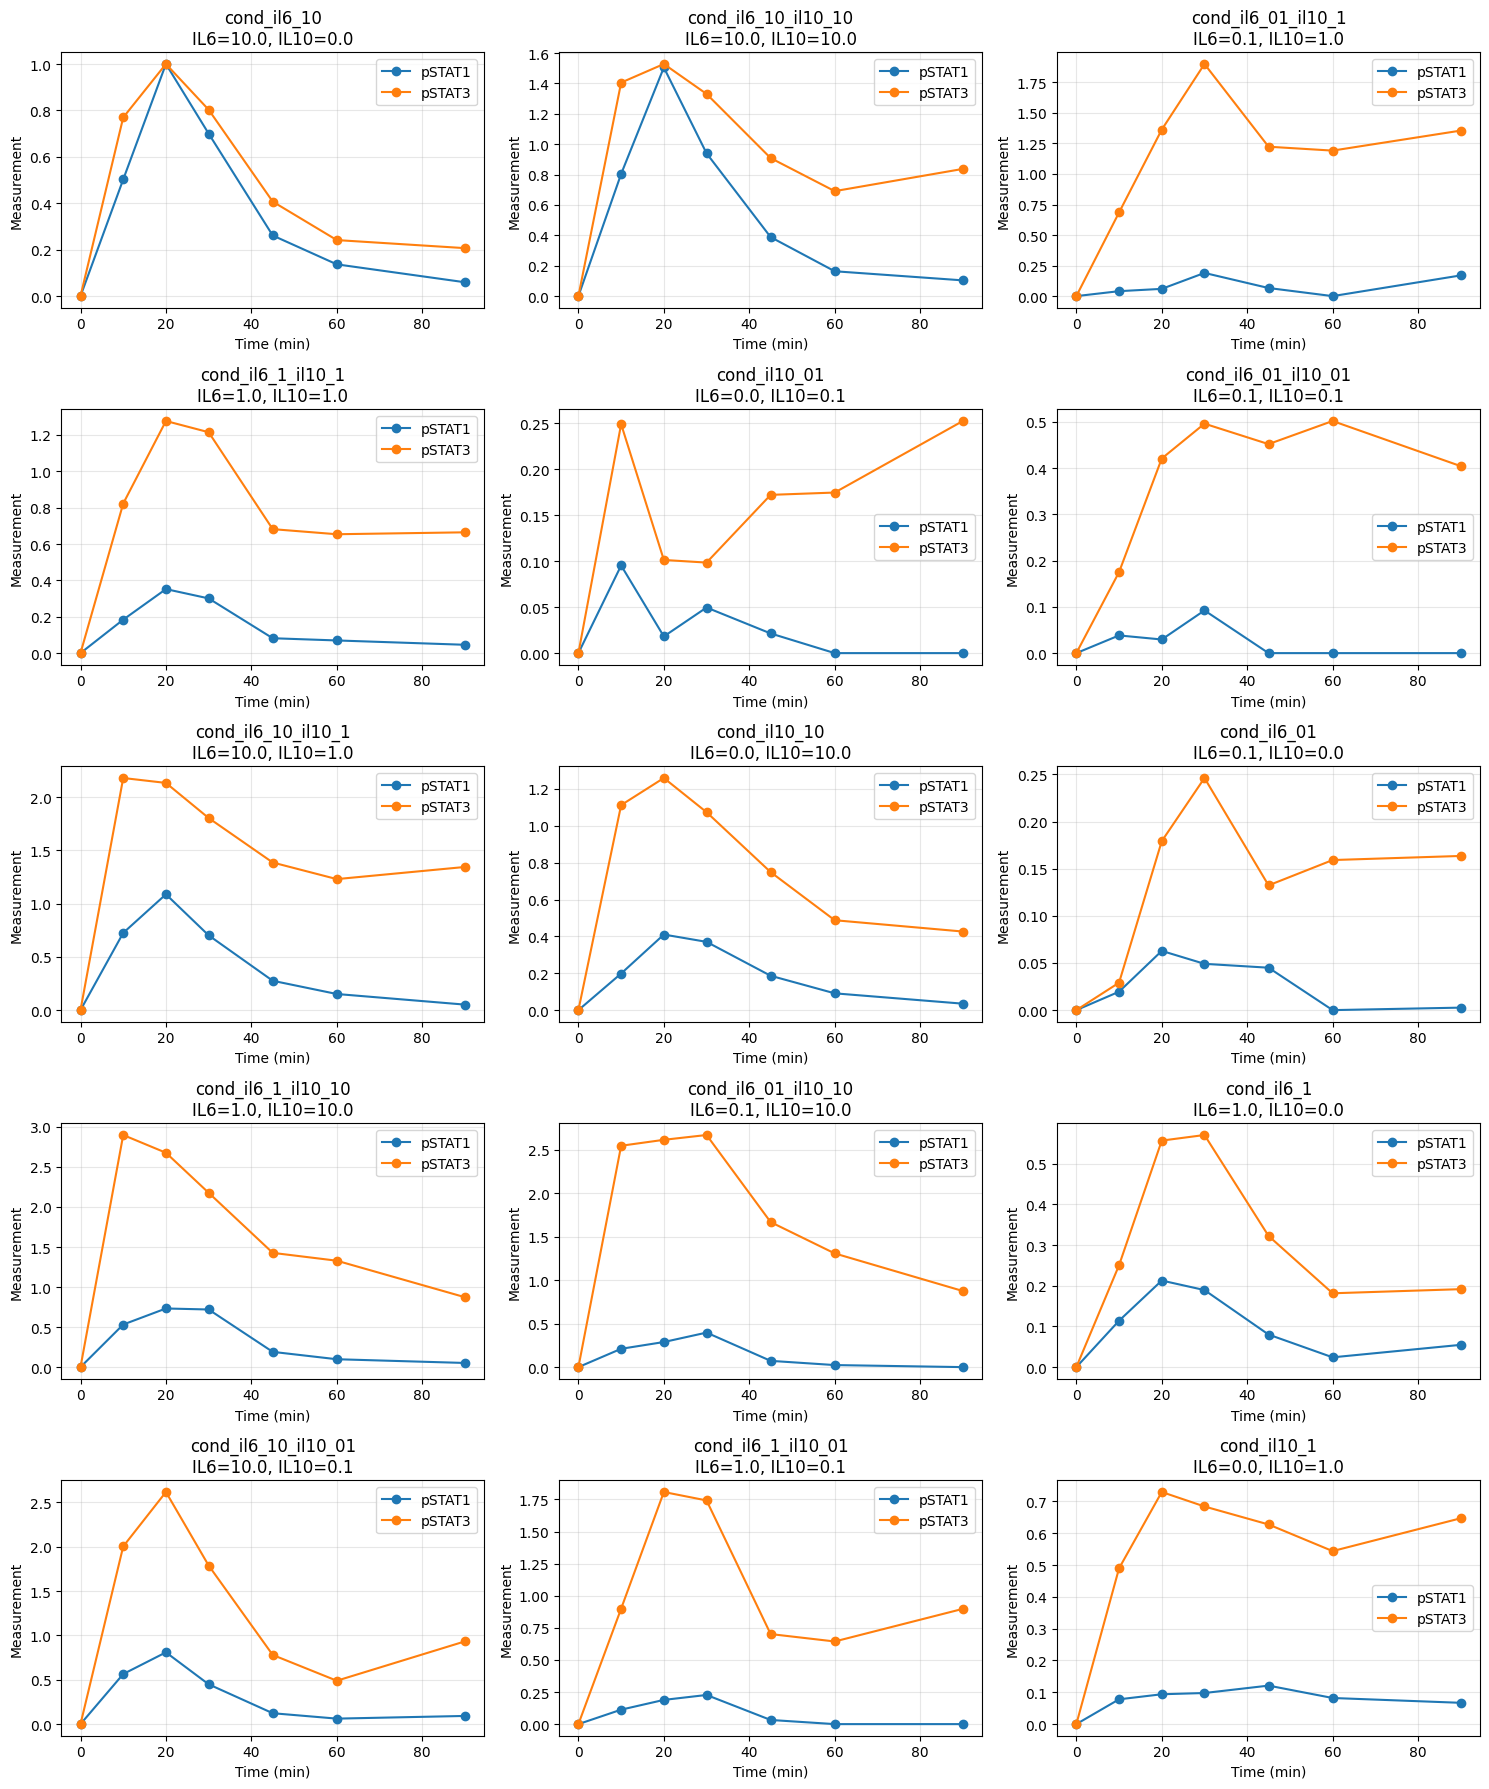

In [11]:
# Plot experimental data
fig, axes = plt.subplots(5, 3, figsize=(15, 18))
axes = axes.flatten()

for idx, cond_id in enumerate(conditions_df['conditionId']):
    ax = axes[idx]
    
    # Get measurements for this condition
    cond_data = measurements_df[measurements_df['simulationConditionId'] == cond_id]
    
    for obs_id in ['obs_total_pS1', 'obs_total_pS3']:
        obs_data = cond_data[cond_data['observableId'] == obs_id]
        if len(obs_data) > 0:
            label = 'pSTAT1' if 'pS1' in obs_id else 'pSTAT3'
            ax.plot(obs_data['time'], obs_data['measurement'], 'o-', label=label)
    
    # Get L1_0 and L2_0 values
    cond_row = conditions_df[conditions_df['conditionId'] == cond_id].iloc[0]
    ax.set_title(f"{cond_id}\nIL6={cond_row['L1_0']}, IL10={cond_row['L2_0']}")
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Measurement')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Create Estimator Instance

The `ParameterEstimator` class is imported from `parameter_estimator.py`.

## Create Estimator Instance

In [12]:
# Create estimator with all parameters
estimator = ParameterEstimator(
    bngl_file="../variable_JAK_STAT_SOCS_degrad_model.bngl",
    conditions_df=conditions_df,
    measurements_df=measurements_df,
    observables_df=observables_df,
    parameters_df=parameters_df
)

print(f"\nEstimable parameters ({len(estimator.estimable_params)}):")
for param in estimator.estimable_params:
    print(f"  {param}")

Initialized estimator with 48 estimable parameters
Timepoints: [ 0. 10. 20. 30. 45. 60. 90.]

Estimable parameters (48):
  il10_complex_jak1_binding
  SOCS3_il6r_unbinding
  il6_jak1_med_STAT1_act
  pSTAT1_rec_dissoc
  il6_complex_jak2_binding
  JAK2_0
  SOCS3_gp130_binding
  SOCS3_gp130_unbinding
  il6_complex_jak2_unbinding
  SOCS3_il6r_binding
  SOCS1_jak1_unbinding
  STAT3_SOCS1_ind
  il6_complex_jak1_unbinding
  il10_complex_jak1_unbinding
  il10_il10r1_unbinding
  STAT1_SOCS3_ind
  il6r_gp130_binding
  GP130_0
  il10_jak1_med_STAT3_act
  IL6R_0
  S3_0
  S1_0
  JAK1_0
  PTP3_0
  pSTAT3_rec_dissoc
  il6_complex_jak1_binding
  il10_jak1_med_STAT1_act
  il10r1_il10r2_unbinding
  il10r1_il10r2_binding
  PTP_med_STAT3_deact
  il6r_gp130_unbinding
  il10_il10r1_binding
  IL10R2_0
  PTP1_0
  il6_jak1_med_STAT3_act
  SOCS3_degrad
  SOCS1_degrad
  IL10R1_0
  il6_jak2_med_STAT3_act
  STAT1_SOCS1_ind
  PTP_med_STAT1_deact
  il6_il6r_binding
  STAT3_SOCS3_ind
  il6_il6r_unbinding
  il6_jak2_m

## Test with Nominal Parameters

In [13]:
# Get nominal parameter values from PETAb
nominal_dict = {}
for param_name in estimator.estimable_params:
    nominal_dict[param_name] = estimator.param_info[param_name]['nominal']

# Convert to vector
nominal_vector = estimator.params_to_vector(nominal_dict)

print("Testing with nominal parameters...")
nllh = estimator.compute_nllh(nominal_vector, verbose=True)
print(f"\nNegative log-likelihood: {nllh:.4f}")

Testing with nominal parameters...
NLLH = 1087467.7030 (210 datapoints)

Negative log-likelihood: 1087467.7030


In [14]:
# Plot fit with nominal parameters
estimator.plot_fit(nominal_vector)

RuntimeError: No sbml element exists for symbol 'sf_pSTAT1'

## Test with Fitted Parameters from CSV

Load one of the fitted parameter sets and evaluate.

In [46]:
# Load fitted parameters
param_sets_df = pd.read_csv('../param_sets.csv')
print(f"Loaded {len(param_sets_df)} parameter sets")

# Use first parameter set
fitted_dict = param_sets_df.iloc[0].to_dict()

# Filter to only estimable parameters and add defaults for missing ones
# IMPORTANT: Exclude L1_0 and L2_0 as these are experimental conditions, not model parameters
fitted_dict_subset = {}
for param_name in estimator.estimable_params:
    # Skip experimental condition parameters
    if param_name in ['L1_0', 'L2_0']:
        fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']
    elif param_name in fitted_dict:
        fitted_dict_subset[param_name] = fitted_dict[param_name]
    else:
        # For missing parameters (like scaling factors), we'll compute them below
        fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']

# Compute scaling factors based on normalization condition
# Scaling factors were determined to normalize observables at t=20 with L1_0=1, L2_0=0
print("\nComputing scaling factors from normalization condition (t=20, L1_0=1, L2_0=0)...")

# Create temporary simulator with fitted parameters (excluding scaling factors)
temp_params = {k: v for k, v in fitted_dict_subset.items() 
               if not k.startswith('sf_') and k not in ['L1_0', 'L2_0']}
temp_sim = BNGLSimulator(estimator.bngl_file, param_values=temp_params)
temp_sim.set_parameter('L1_0', 1.0)
temp_sim.set_parameter('L2_0', 0.0)

# Run simulation to t=20
result_norm = temp_sim.simulate(t_end=20, n_steps=20)
pS1_model_at_20 = result_norm['total_pS1'][-1]
pS3_model_at_20 = result_norm['total_pS3'][-1]

# Get experimental data at t=20 for condition cond_il6_1 (L1_0=1, L2_0=0)
exp_data = measurements_df[measurements_df['simulationConditionId'] == 'cond_il6_1']
exp_data_t20 = exp_data[exp_data['time'] == 20.0]

pS1_exp_at_20 = exp_data_t20[exp_data_t20['observableId'] == 'obs_total_pS1']['measurement'].values[0]
pS3_exp_at_20 = exp_data_t20[exp_data_t20['observableId'] == 'obs_total_pS3']['measurement'].values[0]

# Compute scaling factors
sf_pSTAT1 = pS1_exp_at_20 / pS1_model_at_20
sf_pSTAT3 = pS3_exp_at_20 / pS3_model_at_20

print(f"  sf_pSTAT1 = {sf_pSTAT1:.2f}")
print(f"  sf_pSTAT3 = {sf_pSTAT3:.2f}")

# Update fitted parameters with computed scaling factors
fitted_dict_subset['sf_pSTAT1'] = sf_pSTAT1
fitted_dict_subset['sf_pSTAT3'] = sf_pSTAT3

# Convert to vector
fitted_vector = estimator.params_to_vector(fitted_dict_subset)

print("\nTesting with fitted parameters (set 0)...")
nllh_fitted = estimator.compute_nllh(fitted_vector, verbose=True)
print(f"\nNegative log-likelihood: {nllh_fitted:.4f}")
print(f"Improvement over nominal: {nllh - nllh_fitted:.4f}")

Loaded 12402 parameter sets

Computing scaling factors from normalization condition (t=20, L1_0=1, L2_0=0)...
  sf_pSTAT1 = 24927.76
  sf_pSTAT3 = 268.71

Testing with fitted parameters (set 0)...
NLLH = 8385.8399 (210 datapoints)

Negative log-likelihood: 8385.8399
Improvement over nominal: 16326.0955


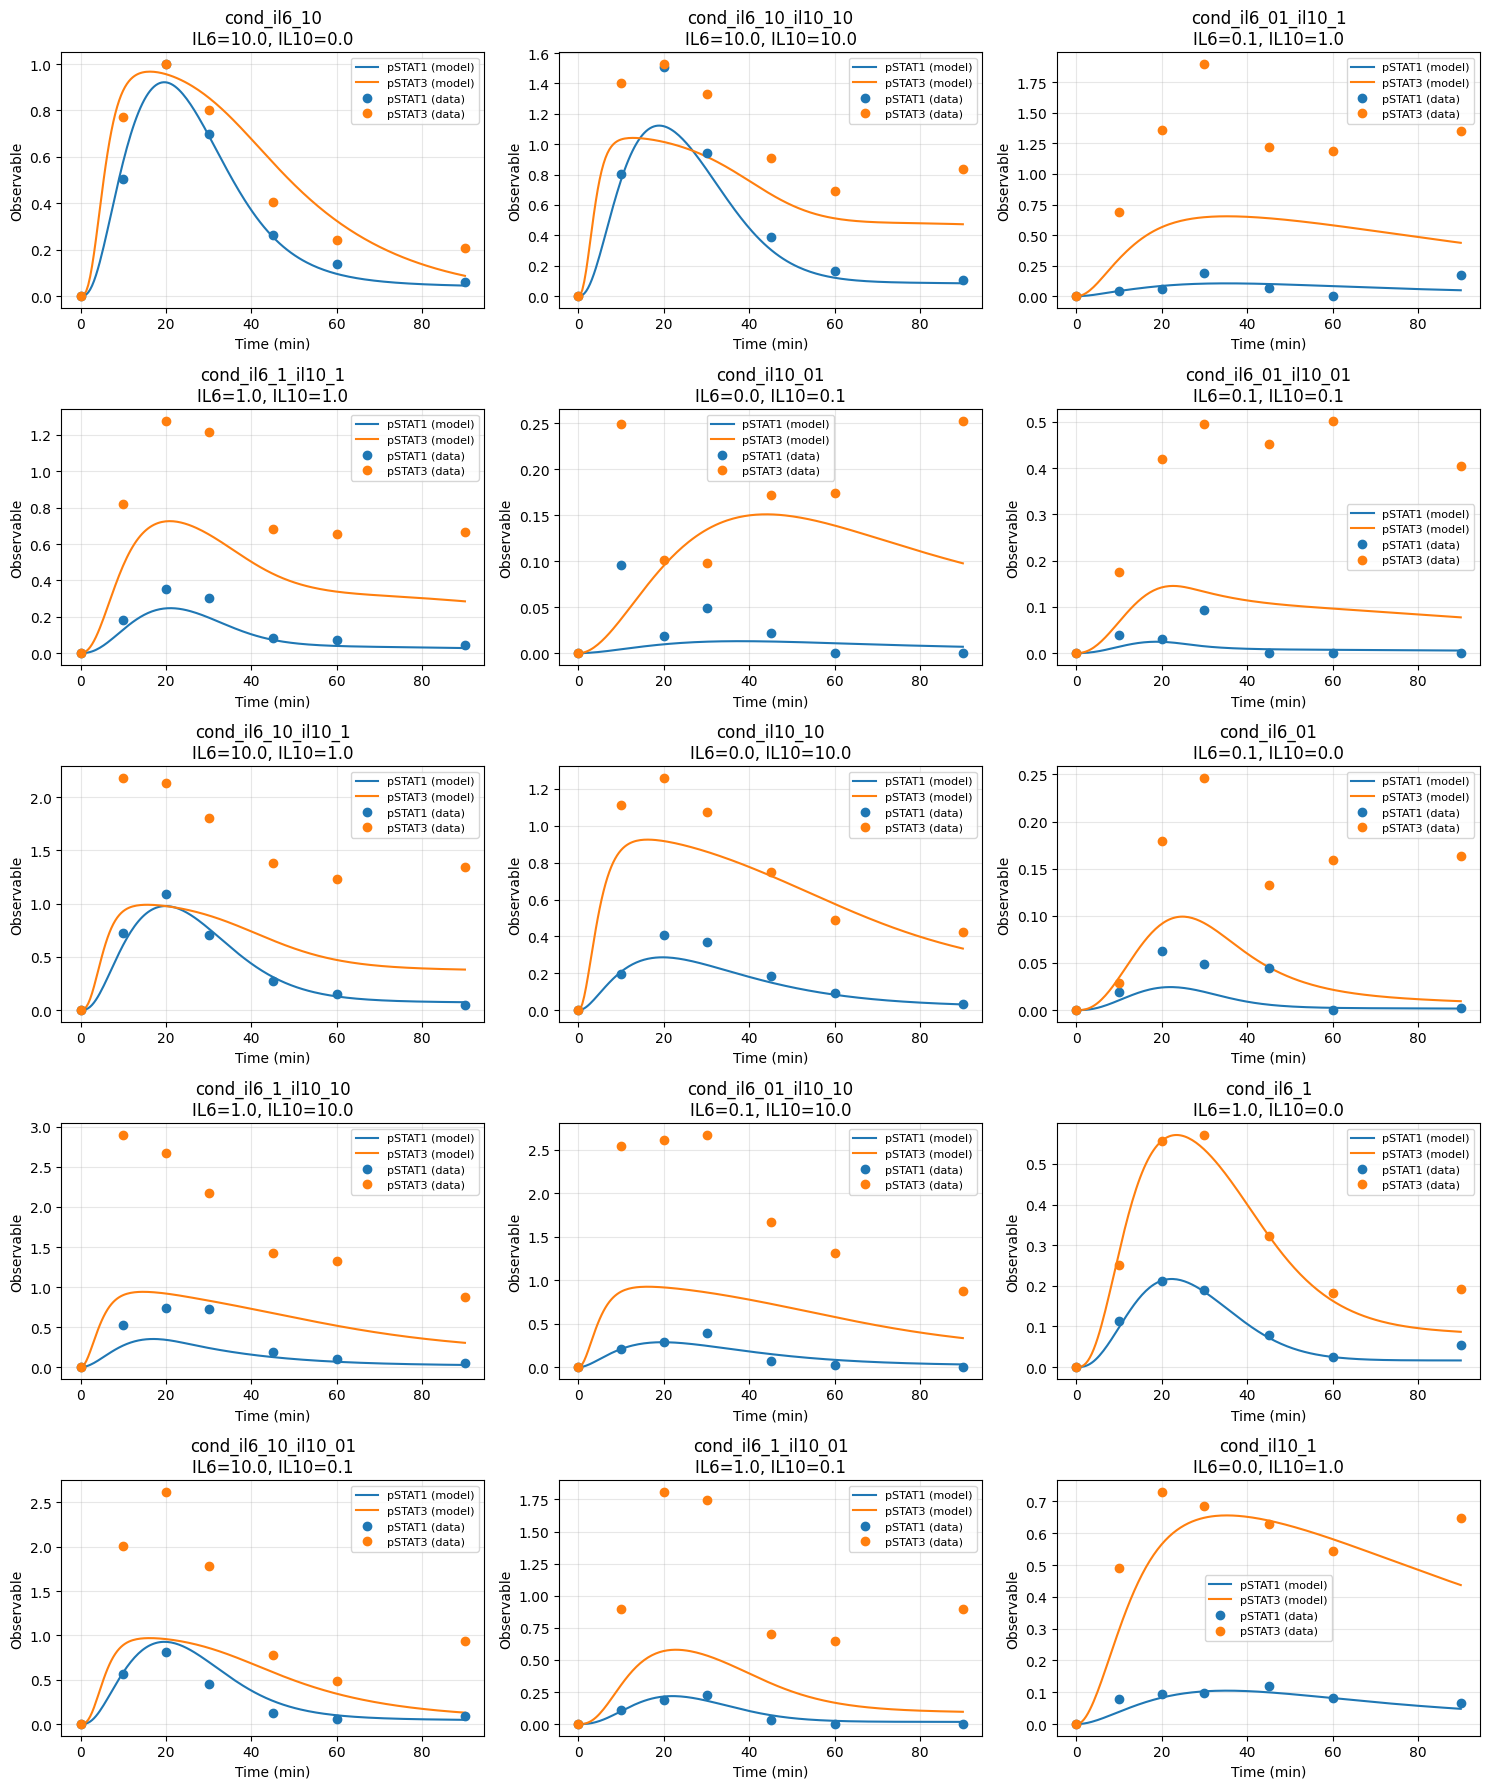

In [47]:
# Plot fit with fitted parameters
estimator.plot_fit(fitted_vector)

## Custom Parameter Subset Estimation

You can create an estimator that only optimizes a subset of parameters.

In [ ]:
# Example: Only estimate scaling factors and a few kinetic parameters
subset_params = [
    'sf_pSTAT1',
    'sf_pSTAT3',
    'il6_jak2_med_STAT3_act',
    'il6_jak1_med_STAT1_act',
    'pSTAT3_rec_dissoc',
    'pSTAT1_rec_dissoc'
]

estimator_subset = ParameterEstimator(
    bngl_file="../variable_JAK_STAT_SOCS_degrad_model.bngl",
    conditions_df=conditions_df,
    measurements_df=measurements_df,
    observables_df=observables_df,
    parameters_df=parameters_df,
    estimable_params=subset_params
)

# Get bounds for subset
lower, upper = estimator_subset.get_bounds()
print(f"\nParameter bounds (log10 scale):")
for i, param in enumerate(subset_params):
    print(f"  {param:30s}: [{lower[i]:6.2f}, {upper[i]:6.2f}]")

## Simple Optimization Example

Demonstrate parameter optimization using scipy.

In [ ]:
from scipy.optimize import minimize

# Get initial guess (nominal values)
x0 = np.array([estimator_subset.param_info[p]['nominal'] for p in subset_params])
x0_transformed = estimator_subset.params_to_vector(
    {p: x0[i] for i, p in enumerate(subset_params)}
)

print("Starting optimization...")
print(f"Initial NLLH: {estimator_subset.compute_nllh(x0_transformed):.4f}")

# Get bounds
bounds = list(zip(*estimator_subset.get_bounds()))

# Run optimization (just a few iterations for demonstration)
result = minimize(
    estimator_subset.compute_nllh,
    x0_transformed,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 20, 'disp': True}
)

print(f"\nOptimization complete!")
print(f"Final NLLH: {result.fun:.4f}")
print(f"Improvement: {estimator_subset.compute_nllh(x0_transformed) - result.fun:.4f}")

# Show optimized parameters
optimized_params = estimator_subset.vector_to_params(result.x)
print(f"\nOptimized parameters:")
for param, value in optimized_params.items():
    print(f"  {param:30s}: {value:.6g}")